# Santander Product Recommendation - Exploratory Data Analysis (EDA)
This notebook performs an EDA on the Santander dataset, focusing on missing values, data types, and initial preprocessing for feature engineering.

## Key Takeaways
1.   Significant Missing Data in Key Features – The dataset has extreme sparsity in certain variables which will require targeted                 imputation or exclusion strategies for robust modeling.
2.	Structural Shift in August 2015 – Both the number of products held per customer and product adoption trends show a sharp change              starting August 2015, likely due to a business or policy change. This shift should be accounted for in modeling to avoid biased              predictions.
3.	Bimodal Customer Tenure & Strong Class Imbalance – Customer tenure distribution is bimodal (many new customers and a smaller cluster         of long-standing ones), and product holding rates reveal that a few products dominate while many are rare. This imbalance is                 critical for model training and evaluation strategy.

## 1. Import Libraries and Load Data
This cell imports necessary libraries (Pandas, NumPy, Seaborn, Matplotlib) and loads the training and testing datasets.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
train_df = pd.read_csv('/Users/niharikadeshpande/Downloads/santander-product-recommendation/train_ver2.csv', low_memory=False)
test_df = pd.read_csv('/Users/niharikadeshpande/Downloads/santander-product-recommendation/test_ver2.csv', low_memory=False)


## 2. Preview the Data
This cell displays the first few rows of both `train_df` and `test_df` to get a sense of the structure and contents.

In [2]:
# Preview
train_df.head()
test_df.head()

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento
0,2016-06-28,15889,F,ES,V,56,1995-01-16,0,256,1,...,N,N,KAT,N,1,28.0,MADRID,1,326124.90,01 - TOP
1,2016-06-28,1170544,N,ES,H,36,2013-08-28,0,34,1,...,N,NaN,KAT,N,1,3.0,ALICANTE,0,NA,02 - PARTICULARES
2,2016-06-28,1170545,N,ES,V,22,2013-08-28,0,34,1,...,N,NaN,KHE,N,1,15.0,"CORUÑA, A",1,NA,03 - UNIVERSITARIO
3,2016-06-28,1170547,N,ES,H,22,2013-08-28,0,34,1,...,N,NaN,KHE,N,1,8.0,BARCELONA,0,148402.98,03 - UNIVERSITARIO
4,2016-06-28,1170548,N,ES,H,22,2013-08-28,0,34,1,...,N,NaN,KHE,N,1,7.0,"BALEARS, ILLES",0,106885.80,03 - UNIVERSITARIO


## 3. Dataset Information and Summary
This cell prints detailed information about both datasets and creates a summary DataFrame showing null counts, total rows, data types, and missing value percentages.

In [3]:
# Preview
print("\nTrain info:")
train_df.info()
print("\nTest info:")
test_df.info()
summary_df = pd.DataFrame({
    "Non-Null Count": train_df.notnull().sum(),
    "Null Count": train_df.isnull().sum(),
    "Total Rows": len(train_df),
    "Data Type": train_df.dtypes,
    "% Missing Values": (train_df.isnull().sum() / len(train_df)) * 100
})
print(summary_df)


Train info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13647309 entries, 0 to 13647308
Data columns (total 48 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   fecha_dato             object 
 1   ncodpers               int64  
 2   ind_empleado           object 
 3   pais_residencia        object 
 4   sexo                   object 
 5   age                    object 
 6   fecha_alta             object 
 7   ind_nuevo              float64
 8   antiguedad             object 
 9   indrel                 float64
 10  ult_fec_cli_1t         object 
 11  indrel_1mes            object 
 12  tiprel_1mes            object 
 13  indresi                object 
 14  indext                 object 
 15  conyuemp               object 
 16  canal_entrada          object 
 17  indfall                object 
 18  tipodom                float64
 19  cod_prov               float64
 20  nomprov                object 
 21  ind_actividad_cliente  float64
 22  ren

## 4. Handling Missing Values - Renta Imputation
This cell imputes missing values in the `renta` (income) column using the mean income within each customer `segmento` group.

In [4]:
#Impute with mode
#segmento is non-numeric, so mean/median is not meaningful.
#Avoids NaN in label encoders or one-hot encoders.

#train_df['segmento'].fillna(train_df['segmento'].mode()[0], inplace=True)

#impute with rent per segmento 
train_df['renta'] = pd.to_numeric(train_df['renta'], errors='coerce')

train_df['renta'] = train_df.groupby('segmento')['renta']\
                            .transform(lambda x: x.fillna(x.mean()))
                            
                            


## 5. Date Conversion and Feature Extraction
This cell converts date columns to datetime format and creates new features such as year, month, day of week, and customer tenure (number of days since account opening).

In [5]:
train_df['fecha_dato'] = pd.to_datetime(train_df['fecha_dato'])
train_df['fecha_alta'] = pd.to_datetime(train_df['fecha_alta'], errors='coerce')

# Extract year and month
train_df['year'] = train_df['fecha_dato'].dt.year
train_df['month'] = train_df['fecha_dato'].dt.month

# Day of week (Monday=0, Sunday=6)
train_df['dayofweek'] = train_df['fecha_dato'].dt.dayofweek

# Customer tenure in days
train_df['customer_tenure'] = (train_df['fecha_dato'] - train_df['fecha_alta']).dt.days  


## Target variable Analysis

This cell extracts the names of all product-related columns that serve as target variables for prediction. In this dataset, the target columns represent whether a customer owns a specific financial product (e.g., credit card, loan, mortgage) in the current month. These columns follow the naming pattern `ind_*_ult1`. Identifying them helps us focus our modeling efforts on the relevant output variables.

In [6]:
#Target variable analysis
product_cols = [col for col in train_df.columns if col.startswith('ind_') and col.endswith('_ult1')]
print(product_cols)  


['ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1', 'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1', 'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1', 'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1', 'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1', 'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1']


## Distribution of Target Variables (Product Holding Rates)

This cell analyzes the distribution of the target variables, i.e., the financial products offered by the bank. It calculates the mean (i.e. the fraction of customers holding each product) for every product column and visualizes it using a horizontal bar plot.

This analysis helps identify:
- Which products are most commonly held by customers (e.g., current accounts or debit cards),
- Which products are rare (e.g., mortgages or pensions),  
- Potential class imbalance in the target variables, which is crucial for modeling and evaluation strategy.

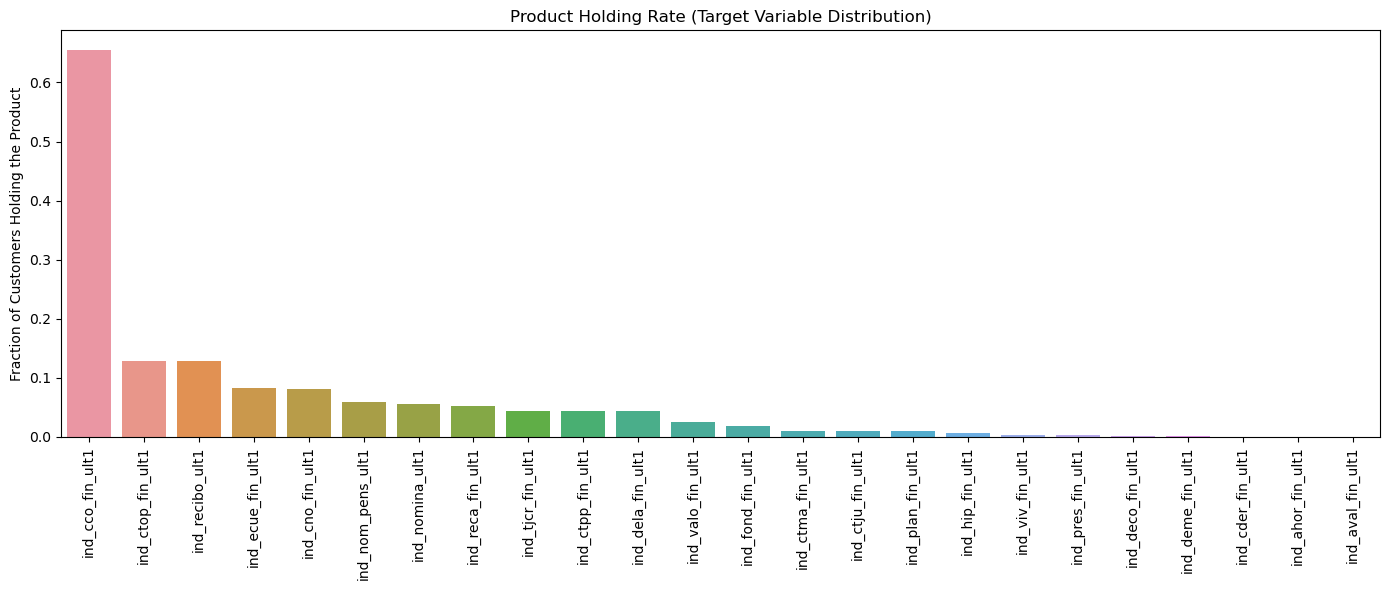

In [7]:
#Distribution of Each Target Variable
import matplotlib.pyplot as plt
import seaborn as sns

product_means = train_df[product_cols].astype(float).mean().sort_values(ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(x=product_means.index, y=product_means.values)
plt.xticks(rotation=90)
plt.ylabel("Fraction of Customers Holding the Product")
plt.title("Product Holding Rate (Target Variable Distribution)")
plt.tight_layout()
plt.show()  


## Distribution for a Specific Product
This shows the class imbalance for a specific target.

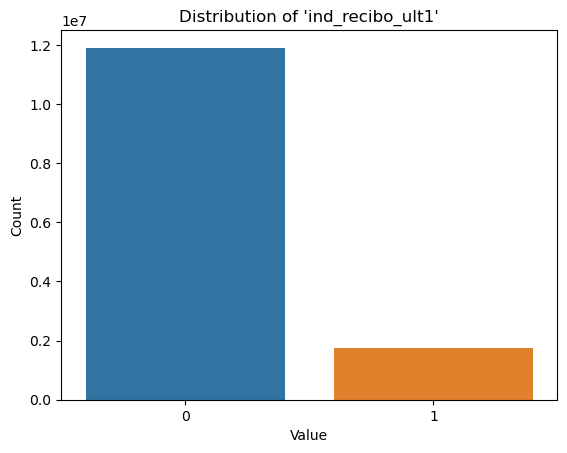

In [8]:
import seaborn as sns
sns.countplot(x='ind_recibo_ult1', data=train_df)
plt.title("Distribution of 'ind_recibo_ult1'")
plt.xlabel("Value")
plt.ylabel("Count")
plt.show()

## Histogram of Numerical Features
This cell creates a histogram to examine the distribution of a numerical feature such as `age`, `renta`, or `antiguedad`.

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


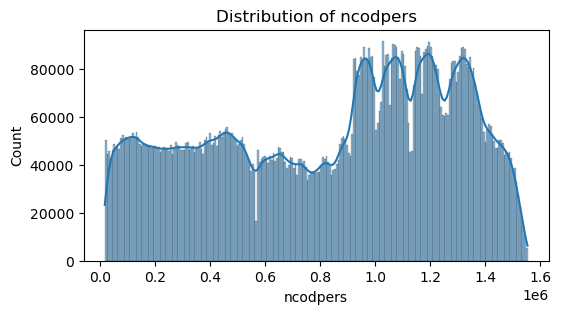

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


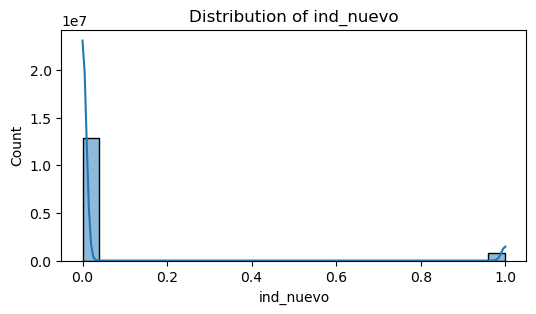

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


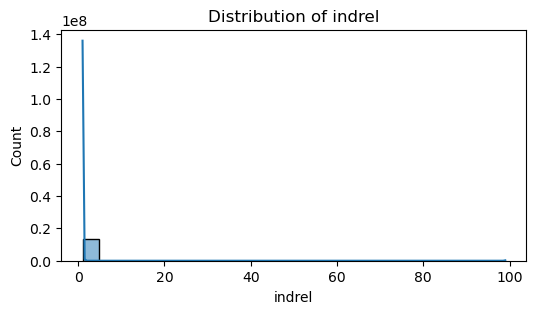

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


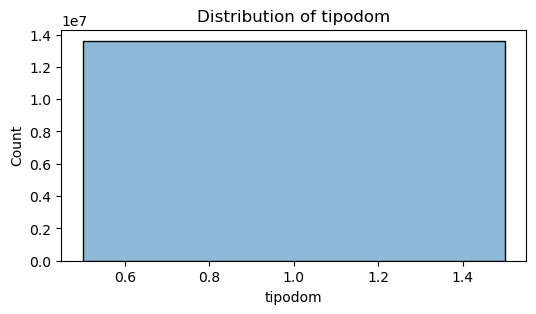

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


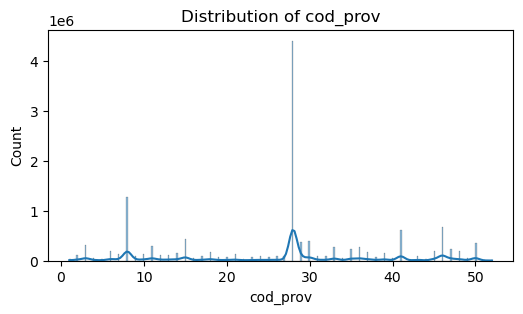

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


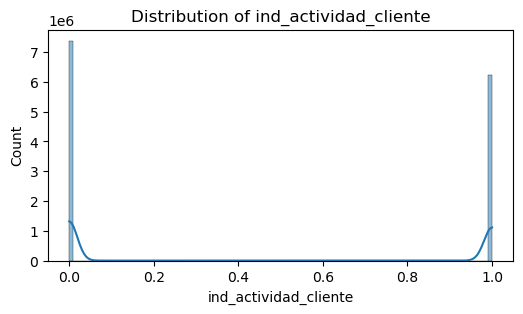

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


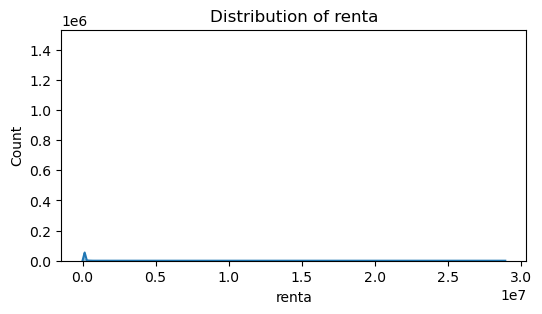

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


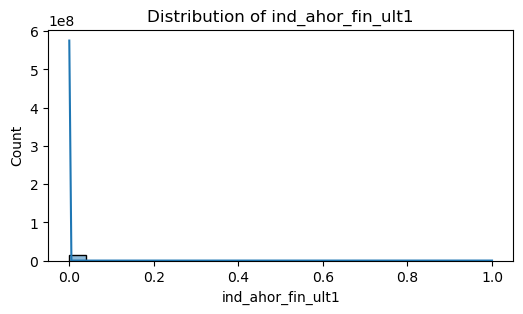

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


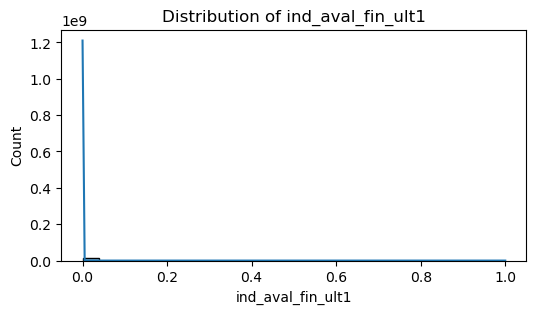

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


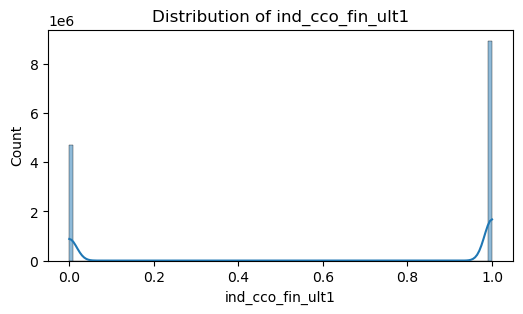

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


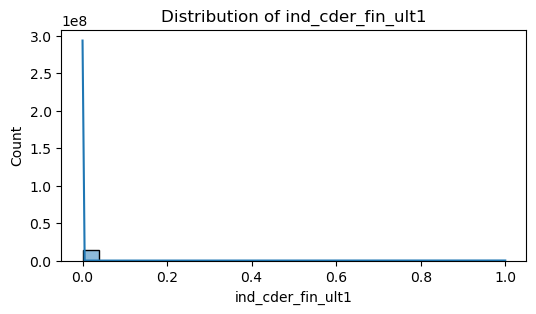

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


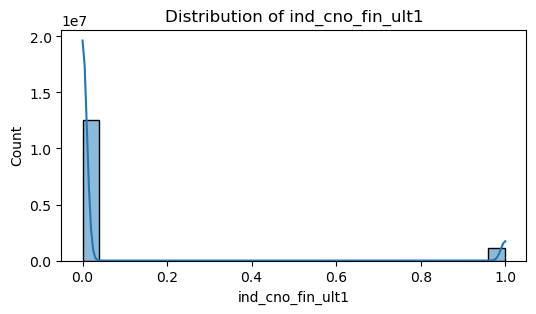

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


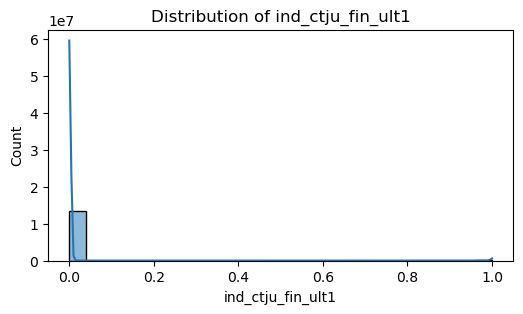

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


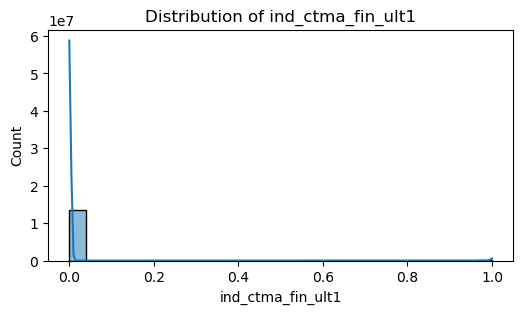

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


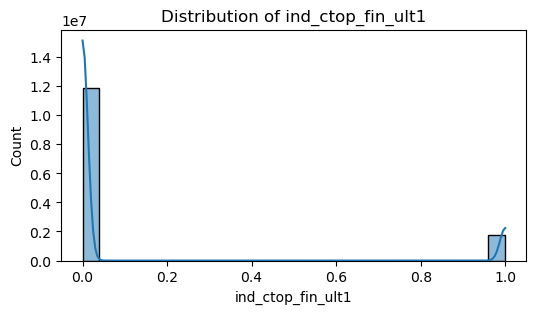

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


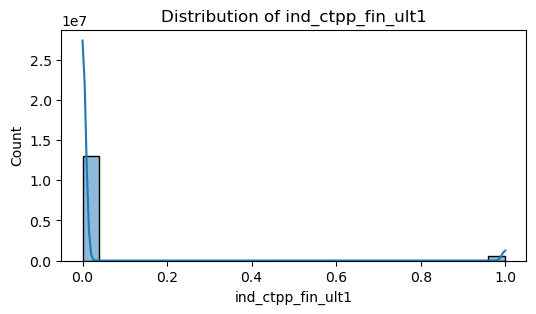

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


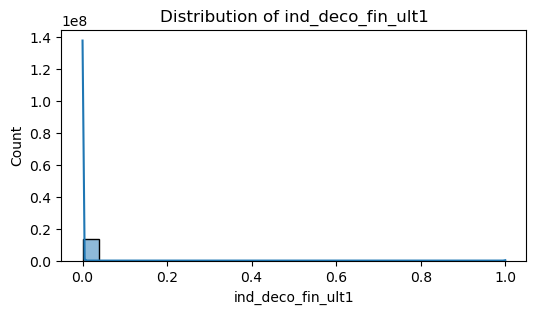

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


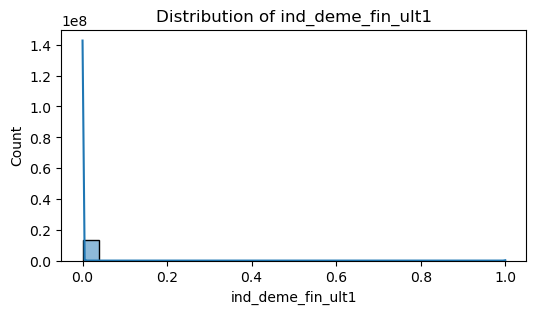

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


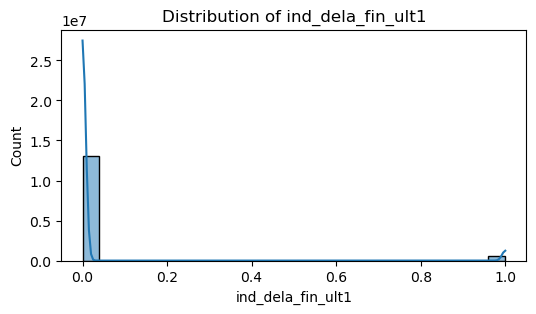

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


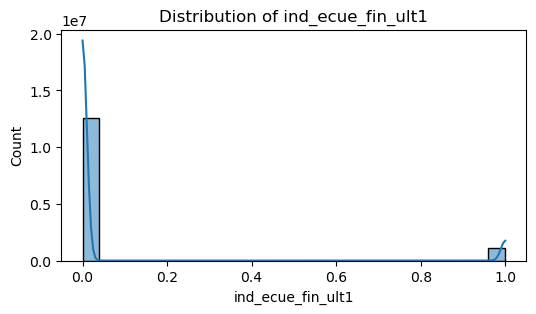

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


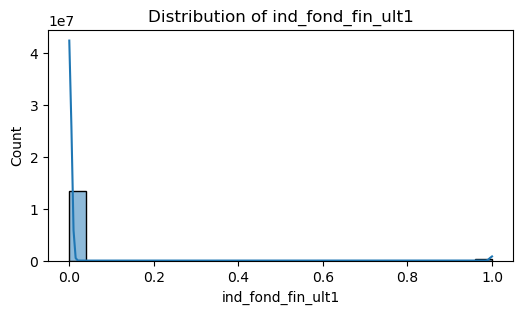

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


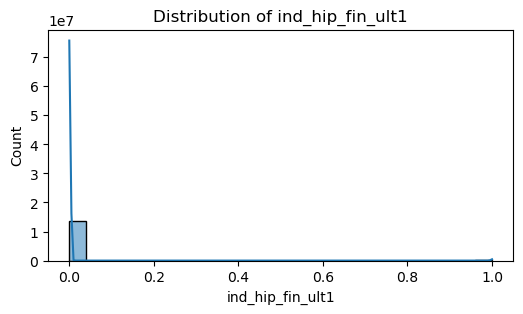

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


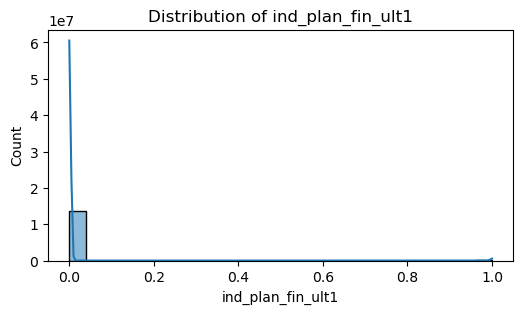

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


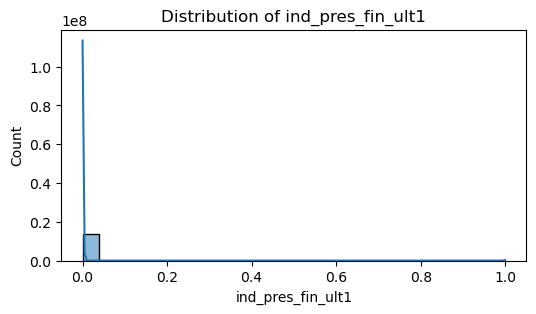

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


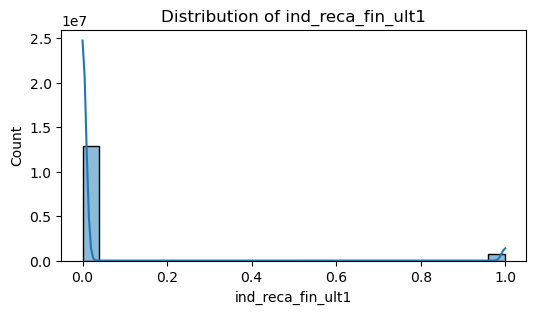

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


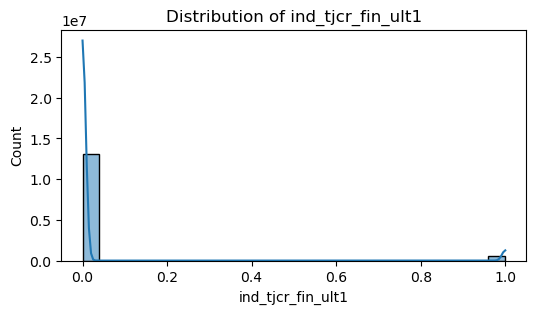

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


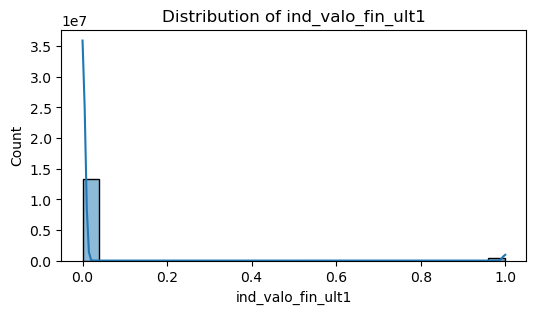

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


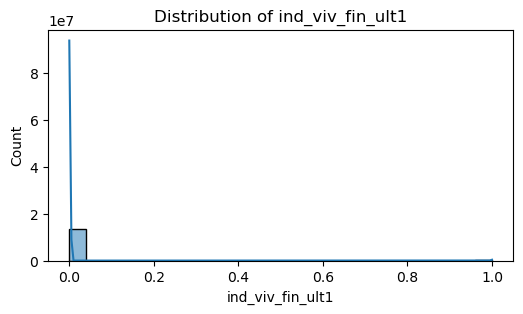

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


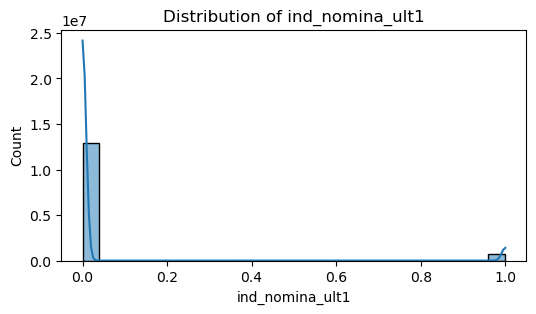

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


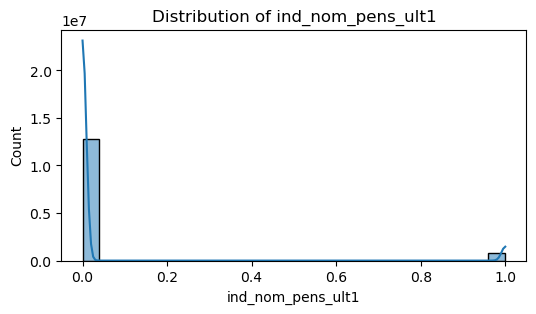

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


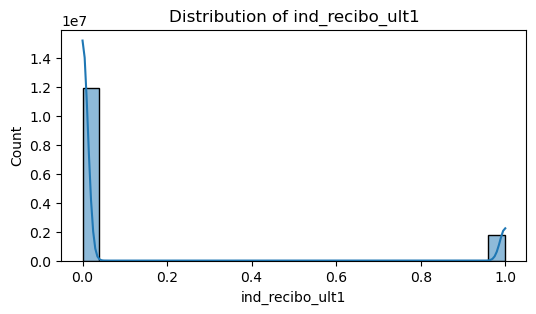

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


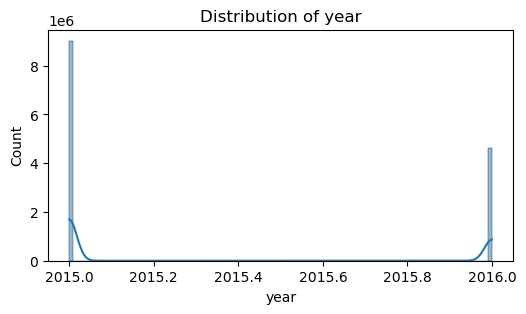

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


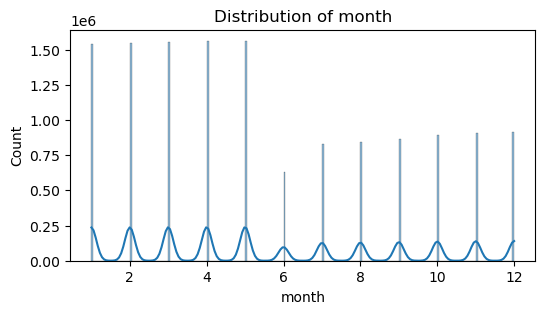

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


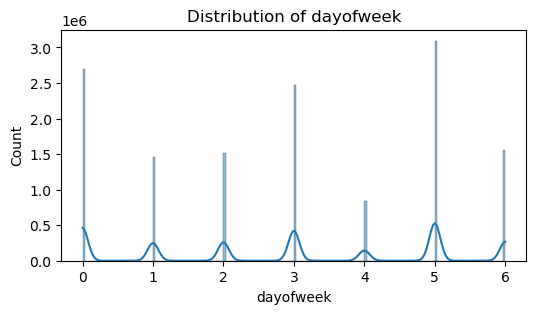

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


In [ ]:
num_cols = train_df.select_dtypes(include=np.number).columns.tolist()

for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.histplot(train_df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

## Columns based on datatype 
This cell lists numeric, binary and categorical columns.

In [3]:
# Numeric columns (exclude product targets)
numeric_cols = ['age', 'antiguedad', 'renta', 'ind_nuevo', 'indrel', 'ind_actividad_cliente']

# Binary product columns (targets)
product_cols = [col for col in train_df.columns if col.startswith('ind_') and col.endswith('_ult1')]

# Categorical columns
categorical_cols = ['sexo', 'segmento', 'canal_entrada', 'pais_residencia', 'ind_empleado']

## Histogram of Numerical Features
This cell creates a histogram to examine the distribution of a numerical feature such as `age`, `renta`, or `antiguedad`.

The histogram of "age" shows bimodal distribution. Box plot shows outliers that needs to be cleaned.

The histogram of 'renta' shows that most customers have relatively low income — the distribution is heavily concentrated near zero. From this plot, we can interprete that there is strong income inequality — most are low-income, with rare high-income outliers.

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


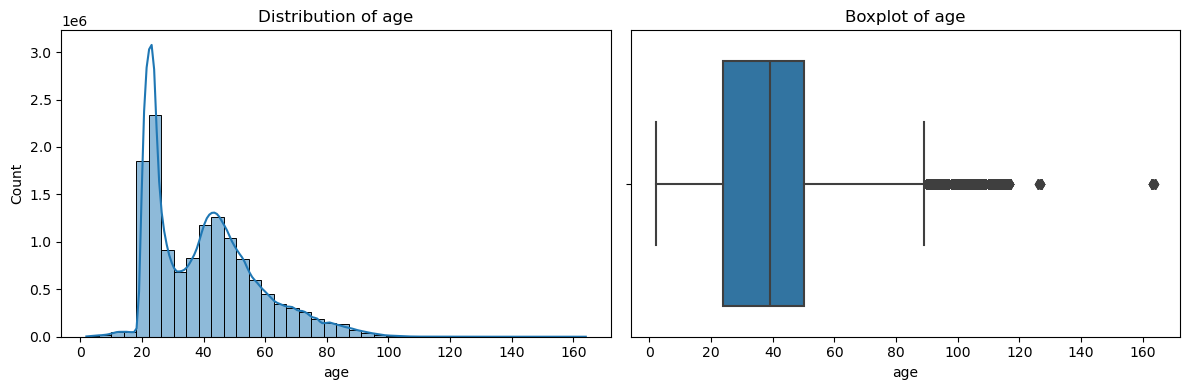

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


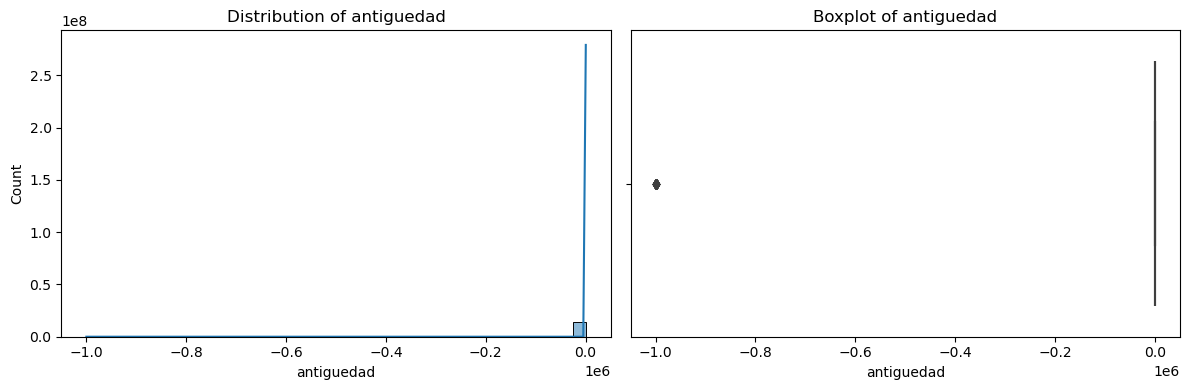

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


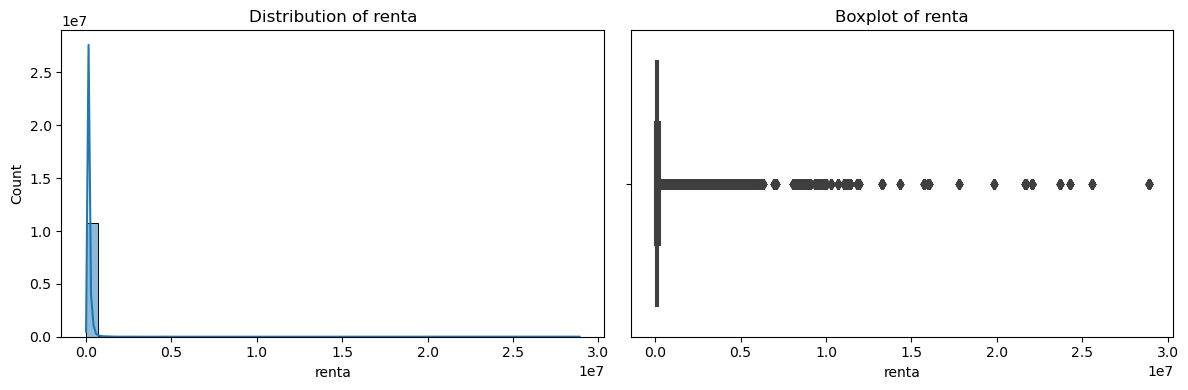

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


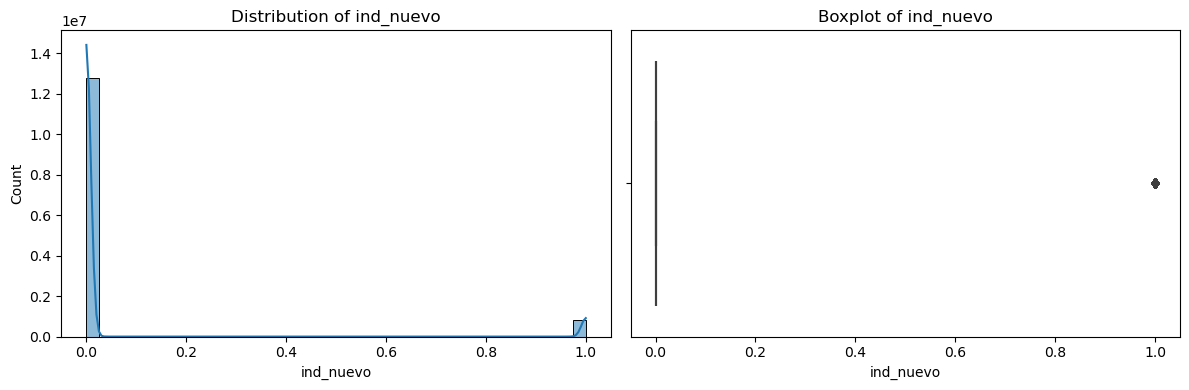

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


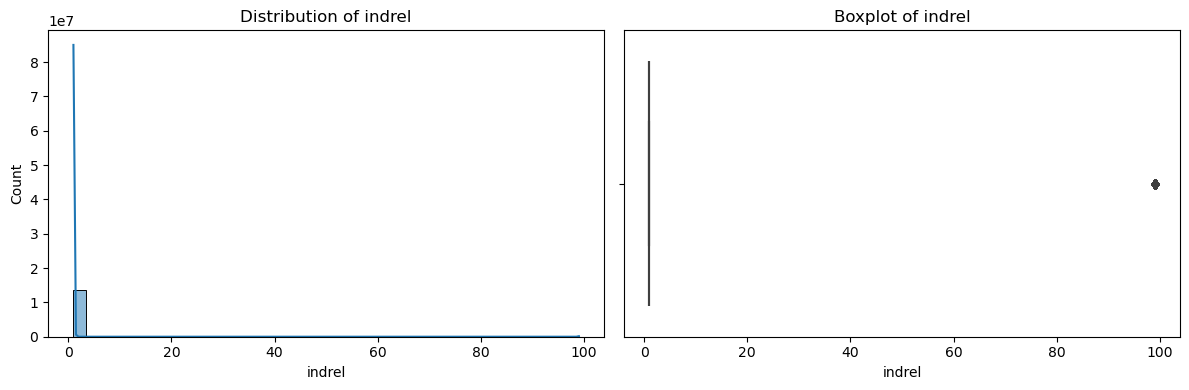

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


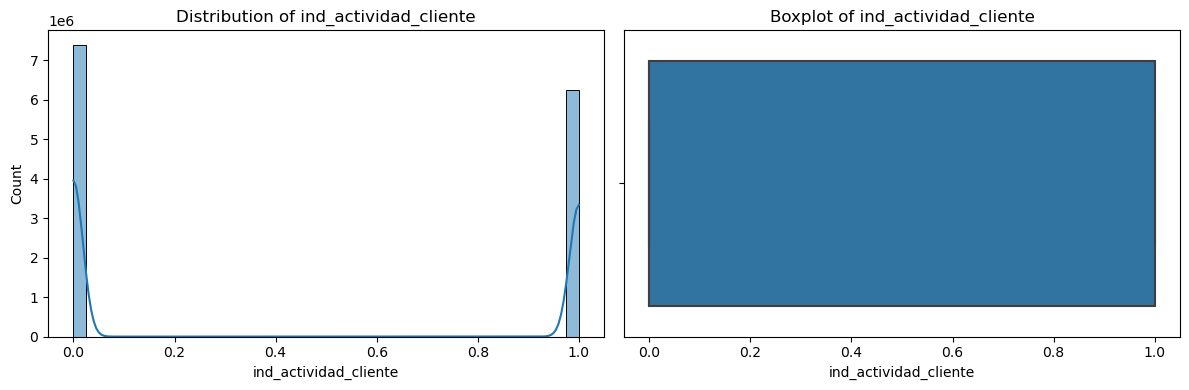

In [4]:
for col in numeric_cols:
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(pd.to_numeric(train_df[col], errors='coerce'), bins=40, kde=True)
    plt.title(f'Distribution of {col}')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=pd.to_numeric(train_df[col], errors='coerce'))
    plt.title(f'Boxplot of {col}')

    plt.tight_layout()
    plt.show()

## Distribution of log-transformed income (renta)
To address the extreme skewness and outliers in renta, a log transformation log(1 + renta) is applied

/var/folders/v6/f7qzcfkj24x9xm011zy79km40000gn/T/ipykernel_1403/2069436020.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_renta'] = np.log1p(df['renta'])
/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


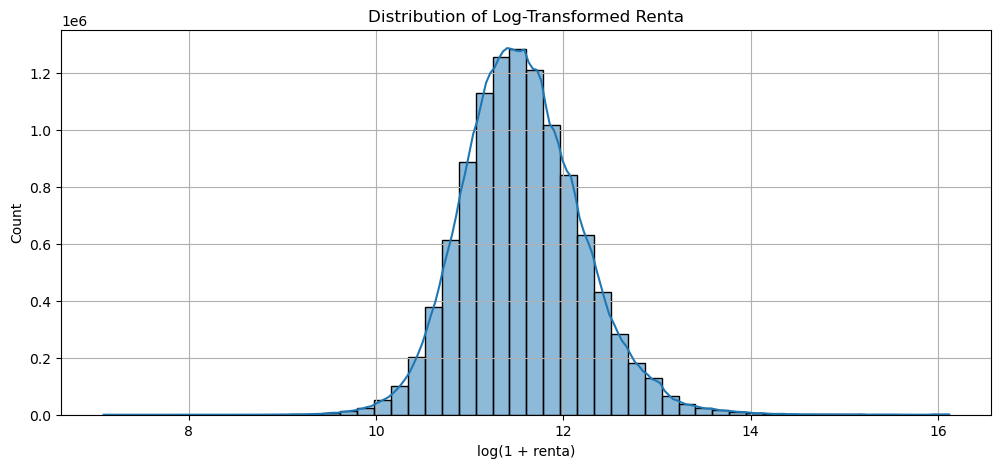

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Optional
warnings.filterwarnings(
    "ignore",
    message="use_inf_as_na option is deprecated",
    category=FutureWarning
)

# Start from a copy 
df = train_df.copy()

# Ensure renta is numeric
df['renta'] = pd.to_numeric(df['renta'], errors='coerce')

# Remove unrealistic highs and any non-finite values
df = df.loc[(df['renta'] < 1e7) & np.isfinite(df['renta'])].copy()

# Log transform (log1p handles zeros)
df['log_renta'] = np.log1p(df['renta'])

df['log_renta'] = df['log_renta'].where(np.isfinite(df['log_renta']), np.nan)

# Plot
plt.figure(figsize=(12, 5))
sns.histplot(df['log_renta'].dropna(), kde=True, bins=50)
plt.title("Distribution of Log-Transformed Renta")
plt.xlabel("log(1 + renta)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

## Count Plot of Categorical Variables
This cell uses `seaborn.countplot()` to show the frequency of each category in a feature.

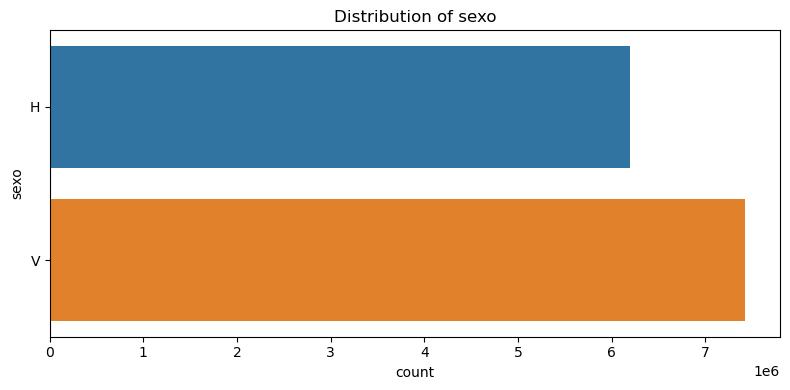

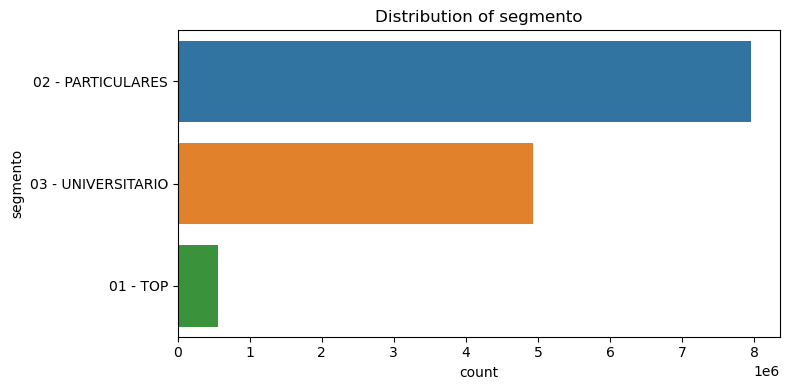

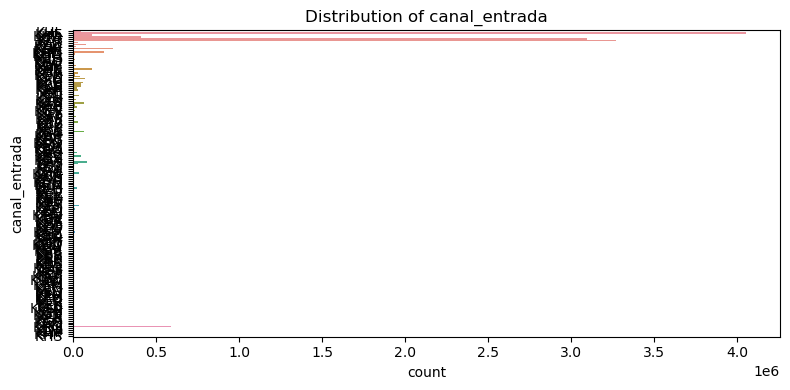

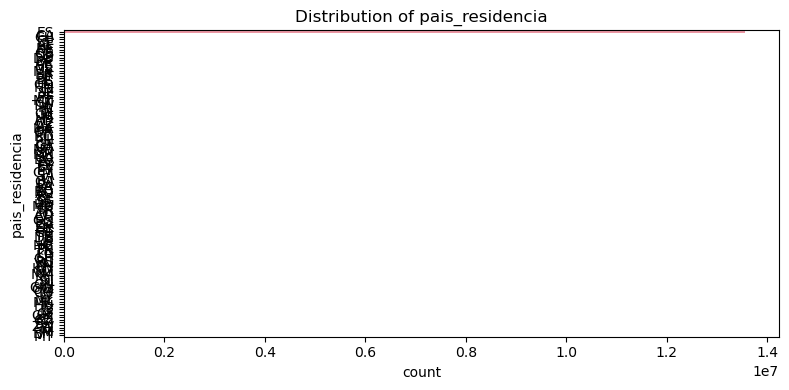

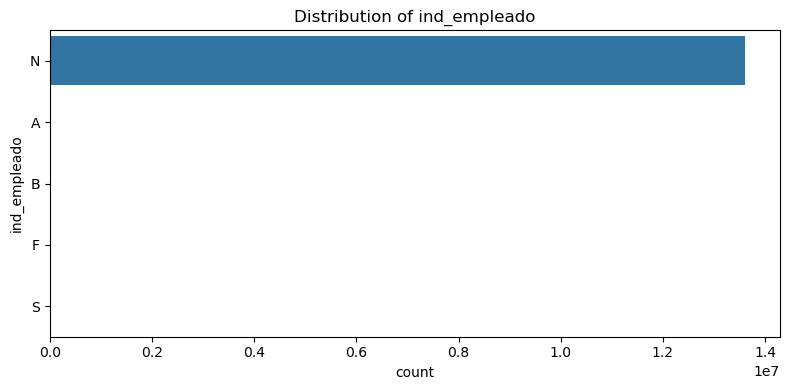

In [6]:
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(y=train_df[col])
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

## Distribution of Categorical Variables
This cell visualizes the distribution of a categorical feature using `value_counts()` and a bar plot.

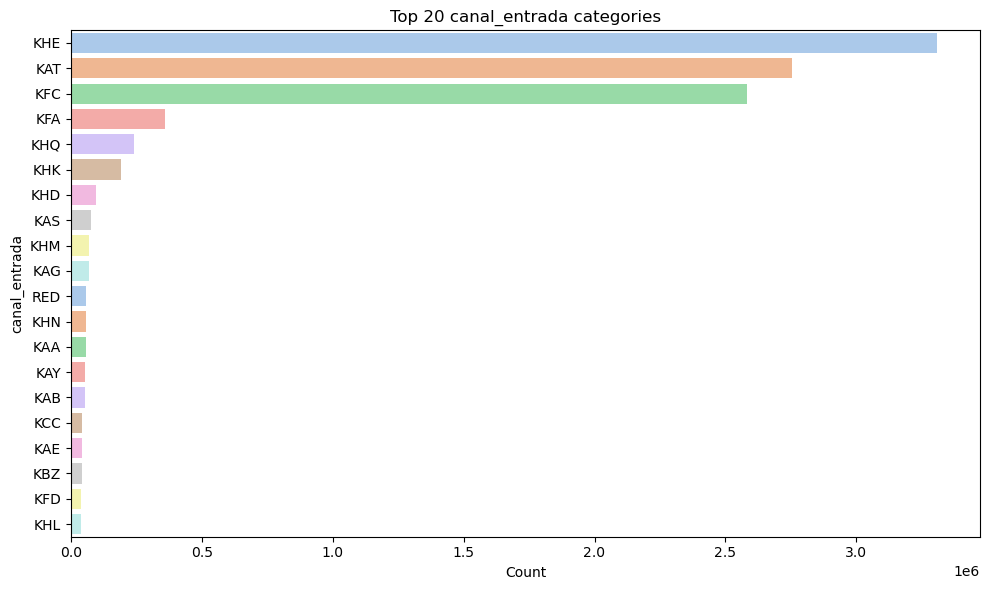

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

top_n = 20
canal_counts = df['canal_entrada'].value_counts().nlargest(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x=canal_counts.values, y=canal_counts.index, palette='pastel')
plt.title('Top 20 canal_entrada categories')
plt.xlabel('Count')
plt.ylabel('canal_entrada')
plt.tight_layout()
plt.show()

## Box Plot Analysis
This cell uses a box plot to visualize the distribution and outliers in numerical data across categorical groups.

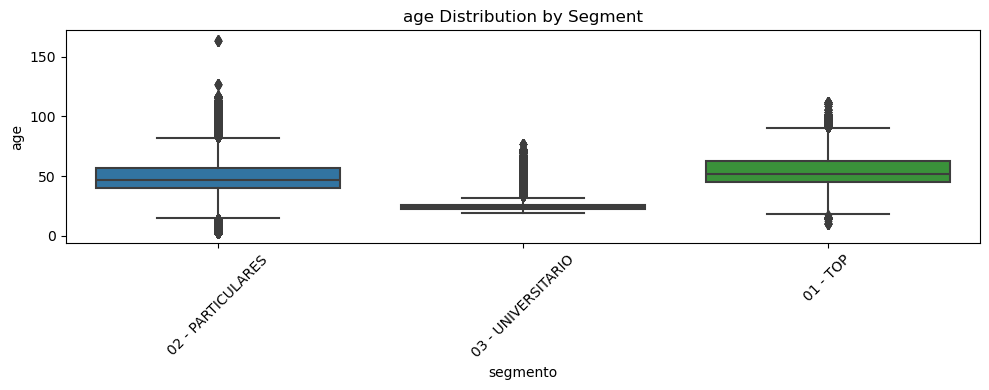

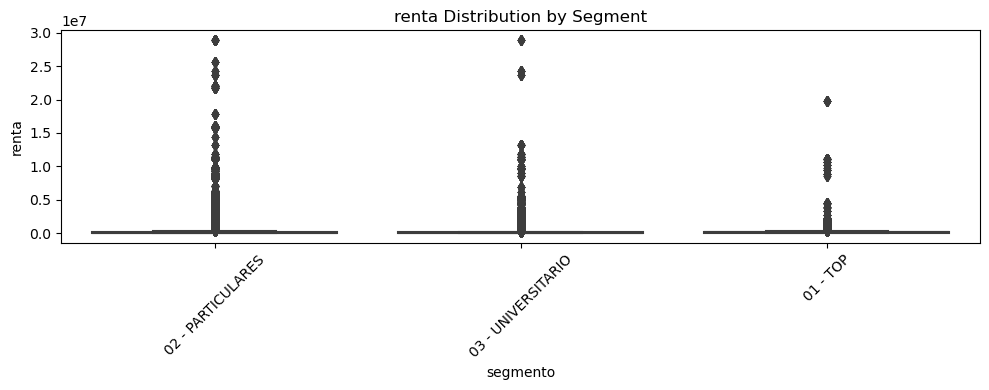

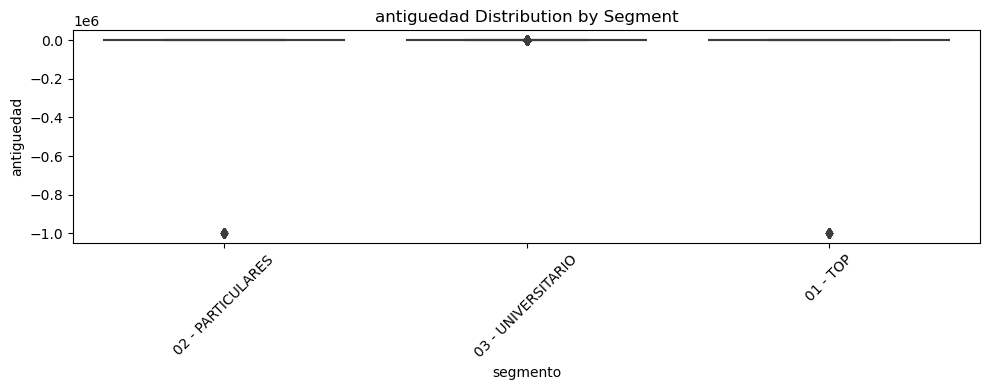

In [8]:
for col in ['age', 'renta', 'antiguedad']:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x='segmento', y=pd.to_numeric(train_df[col], errors='coerce'), data=train_df)
    plt.title(f'{col} Distribution by Segment')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [9]:
selected_cols = ['age', 'antiguedad', 'renta', 'sexo', 'segmento', 'canal_entrada']

## Comparison of distribution of train and test data.
Saving figures in the output_dir

In [10]:
import os

output_dir = "train_test_comparison_figures"
os.makedirs(output_dir, exist_ok=True)

## Distribution of Categorical Variables
This cell compares the distribution of train and test data. This is important step because if distribution of test data is different from train one, the model won't generalize well.

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure consistent types
for col in selected_cols:
    if col in train_df.columns and col in test_df.columns:
        train_df[col] = train_df[col].astype(str)
        test_df[col] = test_df[col].astype(str)

for col in selected_cols:
    if col in ['age', 'antiguedad', 'renta']:  # Numerical columns
        plt.figure(figsize=(8, 4))
        sns.kdeplot(pd.to_numeric(train_df[col], errors='coerce'), label='Train', shade=True)
        sns.kdeplot(pd.to_numeric(test_df[col], errors='coerce'), label='Test', shade=True)
        plt.title(f"Train vs Test Distribution: {col}")
        plt.xlabel(col)
        plt.ylabel("Density")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"{col}_distribution.png"))
        plt.close()
        
    else:  # Categorical columns
        plt.figure(figsize=(10, 4))

        train_counts = train_df[col].value_counts(normalize=True)
        test_counts = test_df[col].value_counts(normalize=True)

        # Combine and align indexes
        compare_df = pd.DataFrame({
            'Train': train_counts,
            'Test': test_counts
        }).fillna(0)

        compare_df[['Train', 'Test']].plot(kind='bar', width=0.8)
        plt.title(f"Train vs Test Distribution: {col}")
        plt.ylabel("Proportion")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"{col}_distribution.png"))
        plt.close()

/var/folders/v6/f7qzcfkj24x9xm011zy79km40000gn/T/ipykernel_1403/2430844400.py:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pd.to_numeric(train_df[col], errors='coerce'), label='Train', shade=True)
/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/v6/f7qzcfkj24x9xm011zy79km40000gn/T/ipykernel_1403/2430844400.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pd.to_numeric(test_df[col], errors='coerce'), label='Test', shade=True)
/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-pa

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

## Correlation Analysis
This cell computes the correlation matrix and plots a heatmap to examine linear relationships among numeric features.

In [12]:
# Product target columns (binary)
product_cols = [col for col in train_df.columns if col.startswith('ind_') and col.endswith('_ult1')]

# Numerical columns (convert to numeric just in case)
numeric_cols = ['age', 'antiguedad', 'renta', 'indrel', 'ind_nuevo', 'ind_actividad_cliente']

# Convert to numeric
for col in numeric_cols:
    train_df[col] = pd.to_numeric(train_df[col], errors='coerce')

# Combine
correlation_cols = numeric_cols + product_cols

## Missing Value Visualization
This cell visualizes the presence of missing values using heatmaps or summaries.

In [13]:
# Subset and drop rows with missing values in numeric cols 
corr_df = train_df[correlation_cols].dropna()

# Compute correlation matrix
corr_matrix = corr_df.corr()

## Correlation Analysis
To assess how features are related to each other and to the target products, a correlation matrix is created combining all numerical features and binary product indicators. 

1. Strong Positive Correlations Between Some Product Pairs
	•	ind_nomina_ult1 and ind_nom_pens_ult1 show a strong positive correlation, implying that customers who receive payroll also often             receive pension—possibly because both relate to income channels.
	•	ind_recibo_ult1 (direct debit) has some correlation with other financial products like ind_cco_fin_ult1 (checking account),                  suggesting complementary usage.
2. Weak Relationship with Demographics
	•	Features like age, antiguedad (seniority), and renta (income) have mild to weak correlation with product indicators. For example:
	    Age has a slightly negative correlation with certain products—perhaps younger customers adopt some products more.
	•	Antiguedad shows some positive trend with product ownership, hinting that long-standing customers may own more products.

Conclusion:
	• No strong multicollinearity — no need to drop features
	• Supports a multi-label prediction setup, since products are not highly co-dependent
	

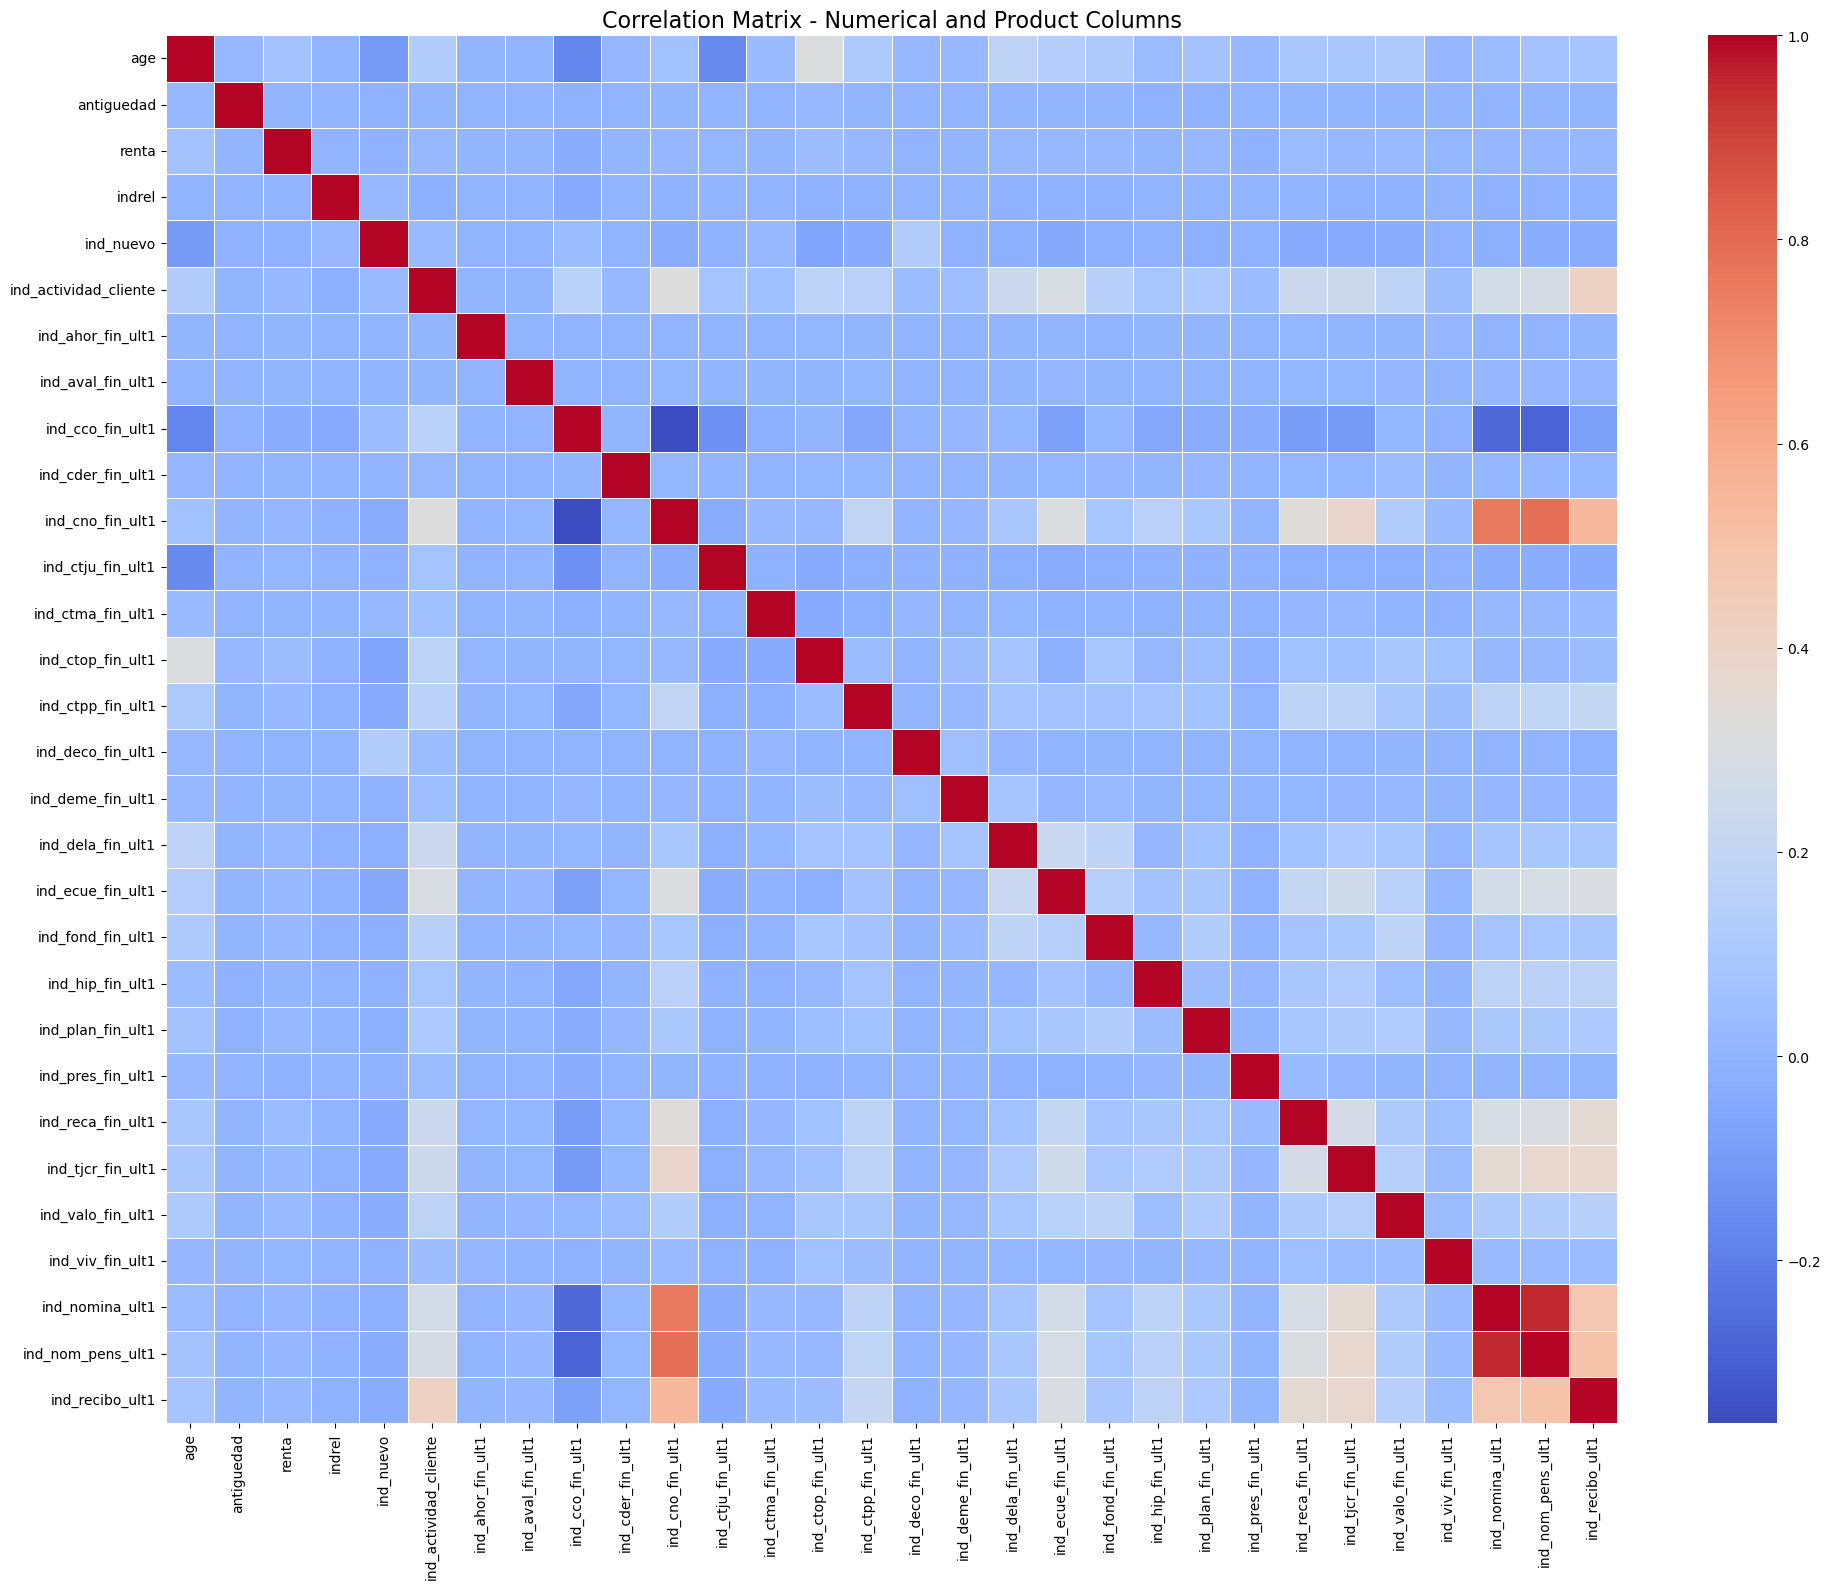

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix - Numerical and Product Columns", fontsize=16)
plt.tight_layout()
plt.savefig("correlation_matrix_full.png")
plt.show()

## Correlation Analysis
This cell computes the correlation matrix and plots a heatmap to examine linear relationships among numeric features.

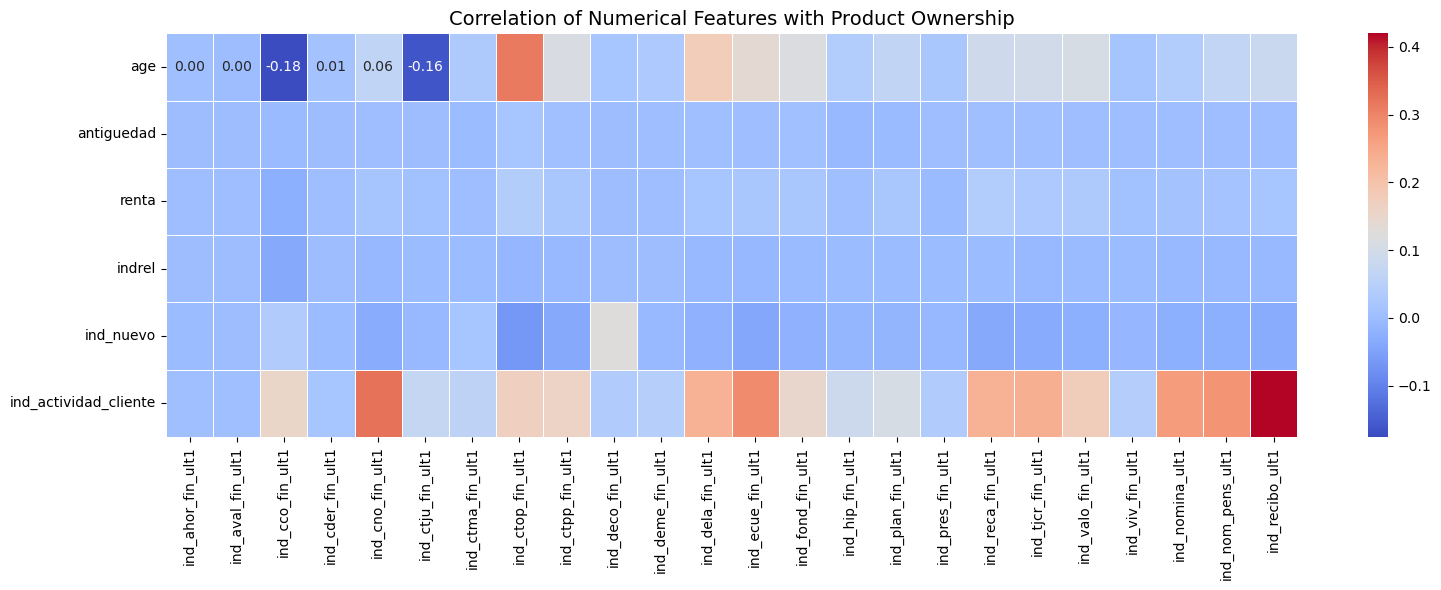

In [15]:
product_corr = corr_matrix.loc[numeric_cols, product_cols]

plt.figure(figsize=(16, 6))
sns.heatmap(product_corr, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation of Numerical Features with Product Ownership", fontsize=14)
plt.tight_layout()
plt.savefig("correlation_numeric_vs_products.png")
plt.show()

## Histogram of Customer tenure days
This plot presents a Customer Tenure Distribution, which shows how long customers have been with the bank (measured in days since joining). It’s a critical insight into customer lifecycle, helping determine whether the dataset is skewed toward new or long-standing customers.

It is a bimodal distribution.

	•	Majority of customers are recently onboarded (0–3 years)
	•	Smaller group of long-term customers (8–15+ years)
	•	Tenure is a critical input feature for understanding behavior and product adoption patterns

In [16]:
train_df['fecha_dato'] = pd.to_datetime(train_df['fecha_dato'])
train_df['fecha_alta'] = pd.to_datetime(train_df['fecha_alta'], errors='coerce')

# Extract components from fecha_dato
train_df['year'] = train_df['fecha_dato'].dt.year
train_df['month'] = train_df['fecha_dato'].dt.month
train_df['month_year'] = train_df['fecha_dato'].dt.to_period('M')

# Customer tenure in days
train_df['customer_tenure_days'] = (train_df['fecha_dato'] - train_df['fecha_alta']).dt.days

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


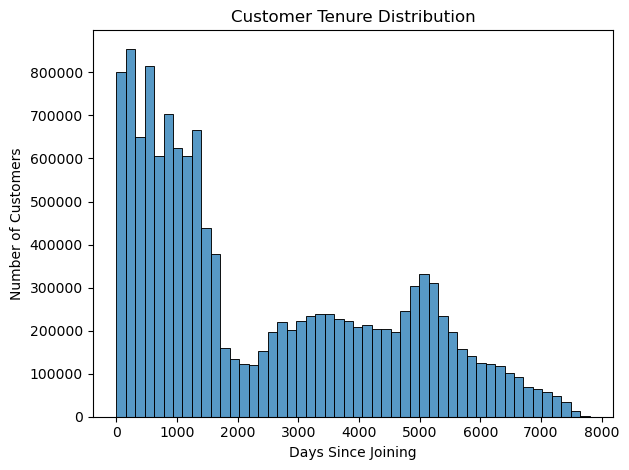

In [17]:
sns.histplot(train_df['customer_tenure_days'].dropna(), bins=50)
plt.title("Customer Tenure Distribution")
plt.xlabel("Days Since Joining")
plt.ylabel("Number of Customers")
plt.tight_layout()
plt.savefig("customer_tenure.png")
plt.show()

## Following cells conduct temporal analysis

## Monthly Record Volume

This analysis visualizes the number of customer records available for each month in the dataset:

- It counts how many entries are present for each `fecha_dato` (date).
- The line plot shows the consistency or variation in data volume over time.

This step is important for:
- Verifying the temporal coverage of the dataset,
- Identifying any missing or incomplete time periods,
- Ensuring a balanced temporal distribution for training time-dependent models.

A consistent number of records across months supports the reliability of time-series modeling and trend analysis.

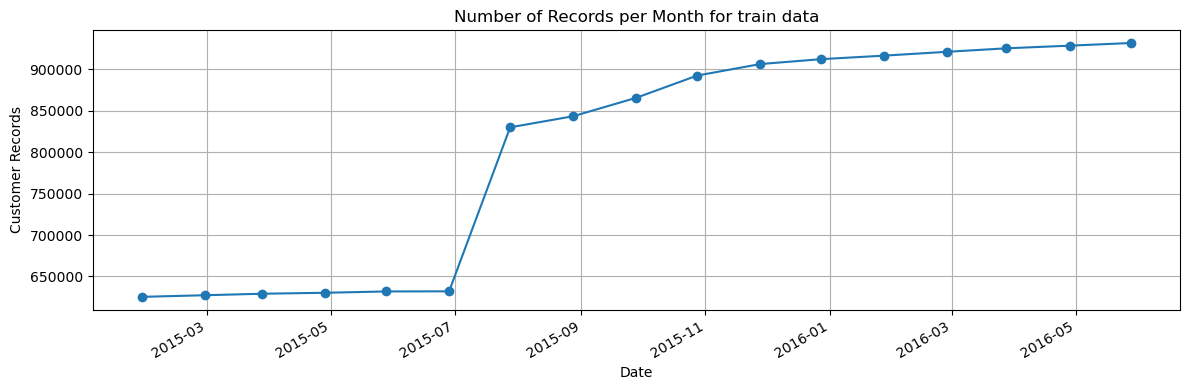

In [18]:
monthly_counts = train_df['fecha_dato'].value_counts().sort_index()

plt.figure(figsize=(12, 4))
monthly_counts.plot(marker='o')
plt.title("Number of Records per Month for train data")
plt.xlabel("Date")
plt.ylabel("Customer Records")
plt.grid(True)
plt.tight_layout()
plt.savefig("no_records_per_month.png")
plt.show()

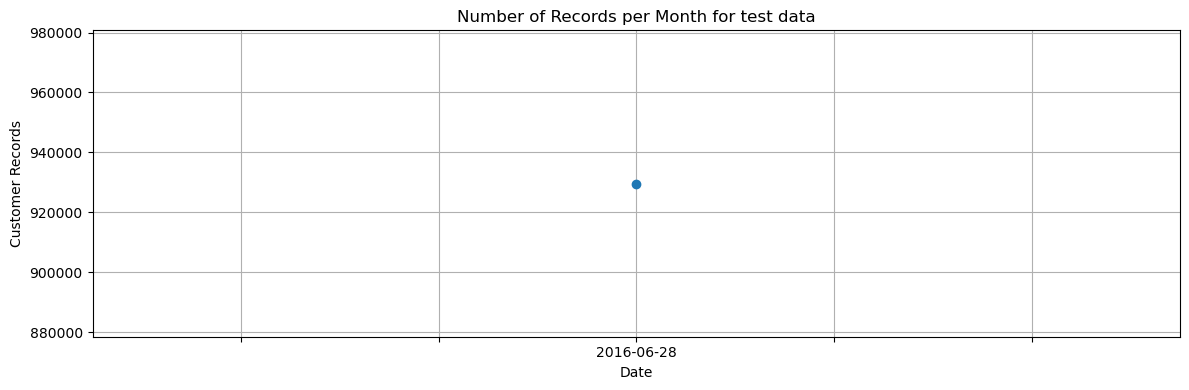

In [19]:
monthly_counts_t = test_df['fecha_dato'].value_counts().sort_index()

plt.figure(figsize=(12, 4))
monthly_counts_t.plot(marker='o')
plt.title("Number of Records per Month for test data")
plt.xlabel("Date")
plt.ylabel("Customer Records")
plt.grid(True)
plt.tight_layout()
plt.savefig("no_records_per_month.png")
plt.show()

## Distribution of Number of Products Held per Customer

This section examines how many financial products each customer holds at a given time:

- A new column `num_products` is created by summing across all product columns for each row.
- The histogram shows the frequency distribution of the number of products held.

This analysis provides insights into:
- Customer engagement levels — e.g., whether most customers use only 1–2 products or a broader portfolio.
- Targeting strategies — identifying under-engaged customers who may benefit from recommendations.
- Class imbalance — helps understand how balanced the dataset is in terms of product adoption diversity.

There is sudden jump in August 2015. It indicates a structural change starting August 2015.

/Users/niharikadeshpande/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


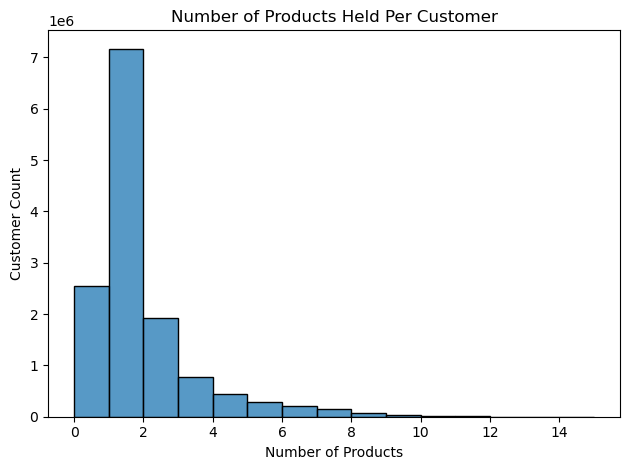

In [20]:
train_df['num_products'] = train_df[product_cols].astype(float).sum(axis=1)

sns.histplot(train_df['num_products'], bins=15, kde=False)
plt.title("Number of Products Held Per Customer")
plt.xlabel("Number of Products")
plt.ylabel("Customer Count")
plt.tight_layout()
plt.show()

## Product Adoption Trends Over Time

This section analyzes how the adoption of specific products changes over time:

- It groups the dataset by `fecha_dato` (monthly snapshots) and computes the mean holding rate for each product.
- The plot visualizes the adoption trends for three of the most common products:
  - `ind_recibo_ult1`: Direct debit
  - `ind_nomina_ult1`: Payroll
  - `ind_cco_fin_ult1`: Current accounts

The trends help:
- Detect seasonal patterns or spikes in product uptake.
- Understand customer behavior over time.
- Inform time-aware recommendation models.

This reflects the structural shift in customer population discussed in the previous plot (i.e., addition of many new customers with fewer products)

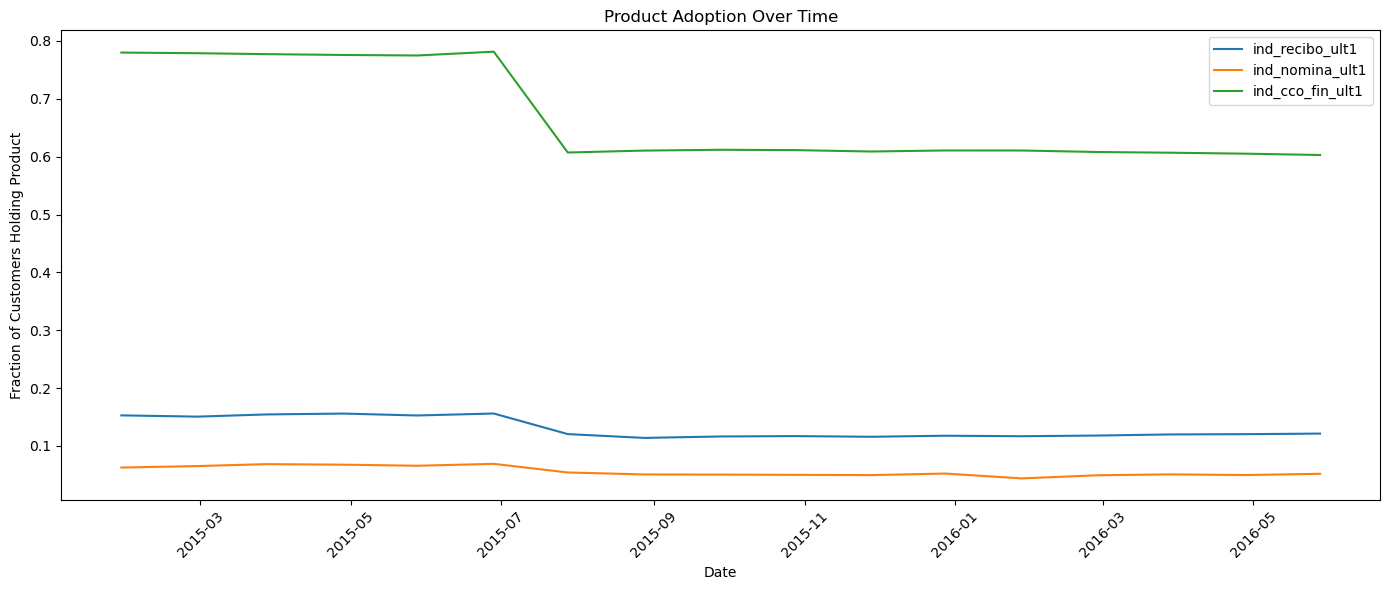

In [21]:
#Product Adoption Over Time

# First converted target product columns to numeric 

product_over_time = train_df.groupby('fecha_dato')[product_cols].mean()

plt.figure(figsize=(14, 6))
for col in ['ind_recibo_ult1', 'ind_nomina_ult1', 'ind_cco_fin_ult1']:  # Top 3 products
    plt.plot(product_over_time.index, product_over_time[col], label=col)

plt.title("Product Adoption Over Time")
plt.xlabel("Date")
plt.ylabel("Fraction of Customers Holding Product")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Grouped Aggregation
This cell performs group-by customer ID and calculate positive difference to get newly added product.

In [23]:
train_df['fecha_dato'] = pd.to_datetime(train_df['fecha_dato'])

# Ensure product columns are numeric
for col in product_cols:
    train_df[col] = pd.to_numeric(train_df[col], errors='coerce')

# Sort to track changes over time
train_df_sorted = train_df.sort_values(['ncodpers', 'fecha_dato'])

In [24]:
# Group by customer and compute product ownership difference
product_diff = train_df_sorted.groupby('ncodpers')[product_cols].diff().fillna(0)

# Positive differences (0 → 1) mean newly added products
product_additions = (product_diff == 1).astype(int)

# Combine with date
product_additions['fecha_dato'] = train_df_sorted['fecha_dato'].values

## Monthly count of new additions for individual product
 Plotted the monthly trends in product additions for three key services.

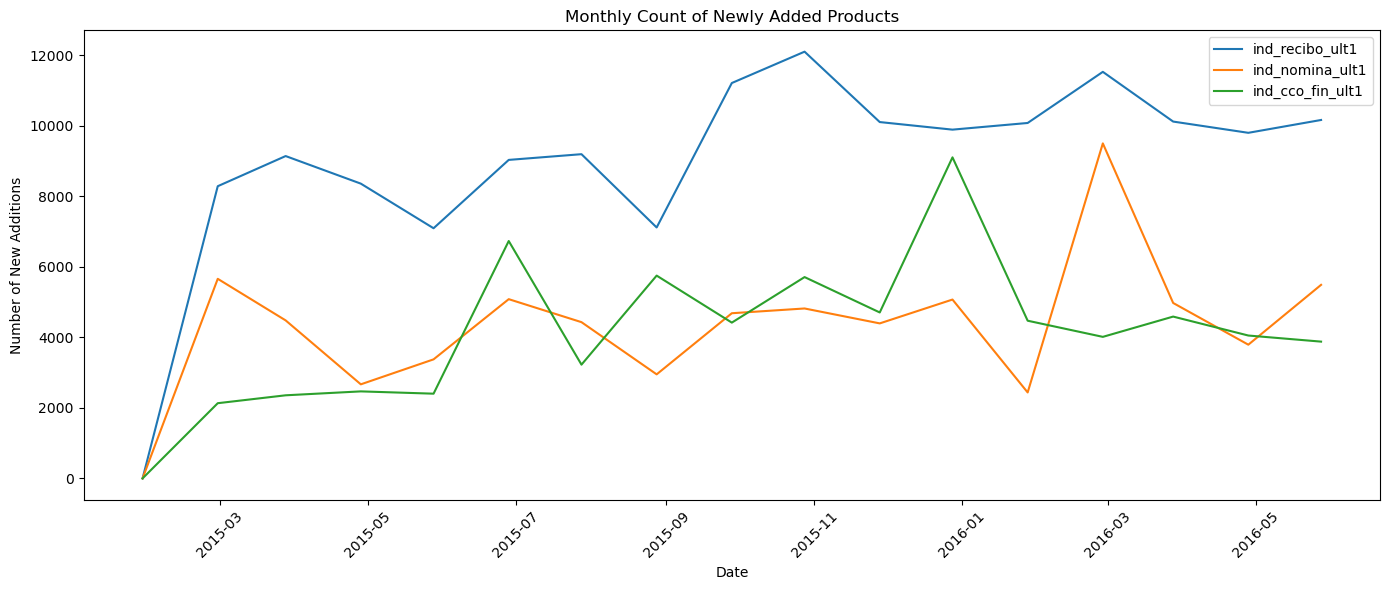

In [25]:
# Sum added products per month
monthly_additions = product_additions.groupby('fecha_dato')[product_cols].sum()

# Plot top 3 products for example
plt.figure(figsize=(14, 6))
for col in ['ind_recibo_ult1', 'ind_nomina_ult1', 'ind_cco_fin_ult1']:
    plt.plot(monthly_additions.index, monthly_additions[col], label=col)

plt.title("Monthly Count of Newly Added Products")
plt.xlabel("Date")
plt.ylabel("Number of New Additions")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Total products added per month
To understand how product engagement evolves over time, this plot help with analyzing how many new products were added by customers each month.

We can observe cyclic behavior or external triggers — for example, spikes around Q1 and Q3 could align with marketing pushes, salary bonuses, or financial year planning.

These fluctuations suggest we should include temporal features in our model — like month, quarter, or time since joining — to help capture seasonality and behavioral cycles.

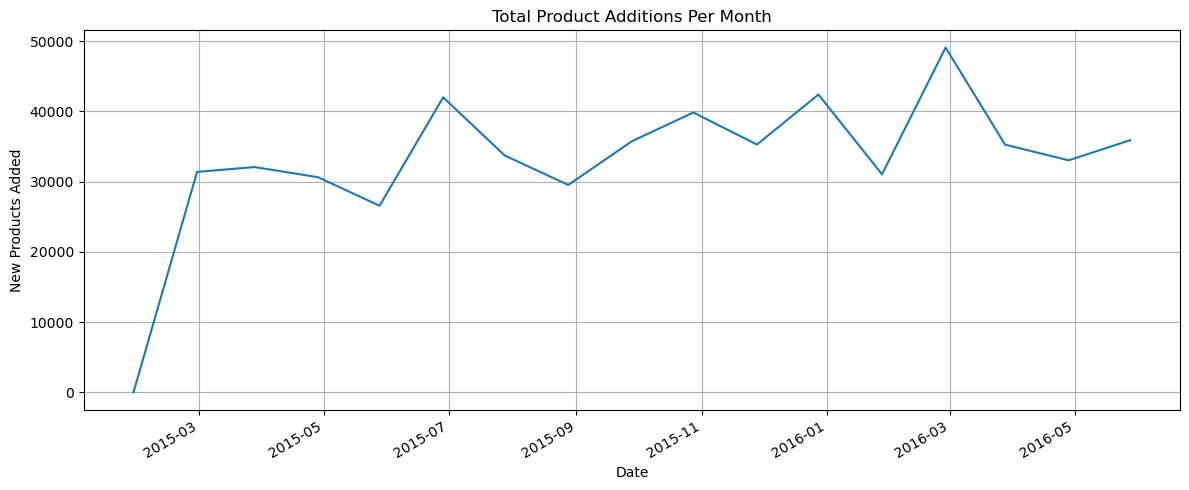

In [26]:
# Assuming product_additions['fecha_dato'] exists
monthly_additions = product_additions.groupby('fecha_dato')[product_cols].sum()

plt.figure(figsize=(12, 5))
monthly_additions.sum(axis=1).plot()
plt.title("Total Product Additions Per Month")
plt.xlabel("Date")
plt.ylabel("New Products Added")
plt.grid(True)
plt.tight_layout()
plt.savefig("total_product_additions.png")
plt.show()

In [4]:
#Finding unique countries and provinces
unique_countries = train_df['pais_residencia'].unique()
print(f"Unique countries ({len(unique_countries)}):", unique_countries)
unique_provinces = train_df['nomprov'].unique()
print(f"Unique provinces ({len(unique_provinces)}):", unique_provinces)

Unique countries (119): ['ES' nan 'CA' 'CH' 'CL' 'IE' 'AT' 'NL' 'FR' 'GB' 'DE' 'DO' 'BE' 'AR' 'VE'
 'US' 'MX' 'BR' 'IT' 'EC' 'PE' 'CO' 'HN' 'FI' 'SE' 'AL' 'PT' 'MZ' 'CN'
 'TW' 'PL' 'IN' 'CR' 'NI' 'HK' 'AD' 'CZ' 'AE' 'MA' 'GR' 'PR' 'RO' 'IL'
 'RU' 'GT' 'GA' 'NO' 'SN' 'MR' 'UA' 'BG' 'PY' 'EE' 'SV' 'ET' 'CM' 'SA'
 'CI' 'QA' 'LU' 'PA' 'BA' 'BO' 'AU' 'BY' 'KE' 'SG' 'HR' 'MD' 'SK' 'TR'
 'AO' 'CU' 'GQ' 'EG' 'ZA' 'DK' 'UY' 'GE' 'TH' 'DZ' 'LB' 'JP' 'NG' 'PK'
 'TN' 'TG' 'KR' 'GH' 'RS' 'VN' 'PH' 'KW' 'NZ' 'MM' 'KH' 'GI' 'SL' 'GN'
 'GW' 'OM' 'CG' 'LV' 'LT' 'ML' 'MK' 'HU' 'IS' 'LY' 'CF' 'GM' 'KZ' 'CD'
 'BZ' 'ZW' 'DJ' 'JM' 'BM' 'MT']
Unique provinces (53): ['MALAGA' 'CIUDAD REAL' 'ZARAGOZA' 'TOLEDO' 'LEON' 'GIPUZKOA' 'CACERES'
 'GIRONA' 'ZAMORA' 'BARCELONA' 'SALAMANCA' 'BURGOS' 'HUESCA' 'NAVARRA'
 'AVILA' 'SEGOVIA' 'LUGO' 'LERIDA' 'MADRID' 'ALICANTE' 'SORIA' 'SEVILLA'
 'CANTABRIA' 'BALEARS, ILLES' 'VALLADOLID' 'PONTEVEDRA' 'VALENCIA'
 'TERUEL' 'CORUÑA, A' 'OURENSE' 'JAEN' 'CUENCA' 'BIZKAIA' 'CASTELL

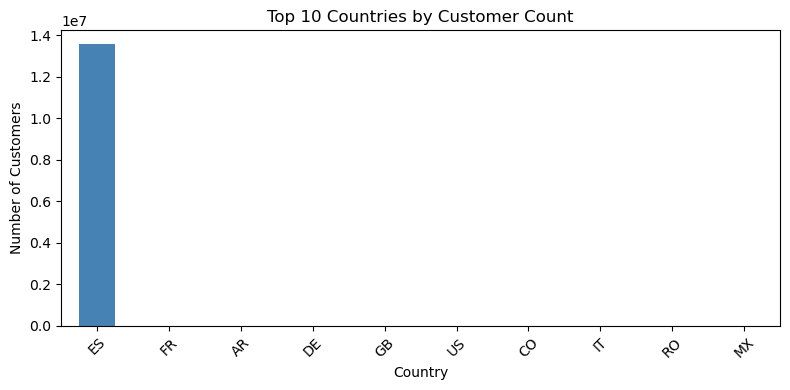

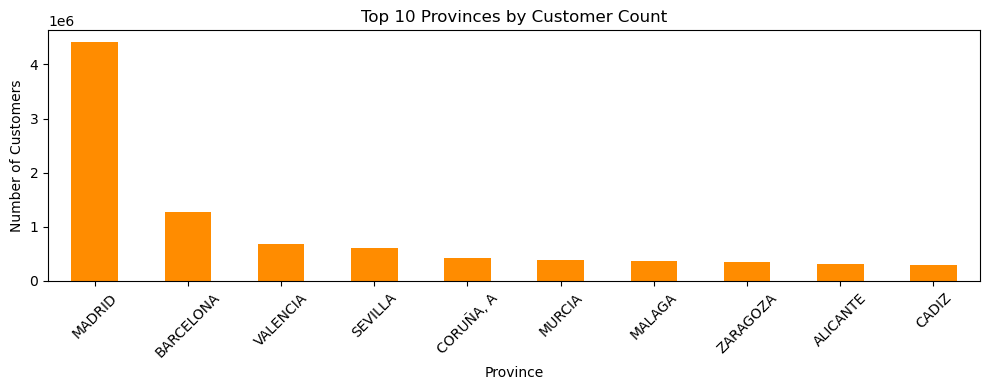

In [5]:
#Histogram of Customers by Country and province
import matplotlib.pyplot as plt

# --- Top 10 Countries ---
top_countries = train_df['pais_residencia'].value_counts().head(10)

plt.figure(figsize=(8,4))
top_countries.plot(kind='bar', color='steelblue')
plt.title("Top 10 Countries by Customer Count")
plt.ylabel("Number of Customers")
plt.xlabel("Country")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Top 10 Provinces ---
top_provinces = train_df['nomprov'].value_counts().head(10)

plt.figure(figsize=(10,4))
top_provinces.plot(kind='bar', color='darkorange')
plt.title("Top 10 Provinces by Customer Count")
plt.ylabel("Number of Customers")
plt.xlabel("Province")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

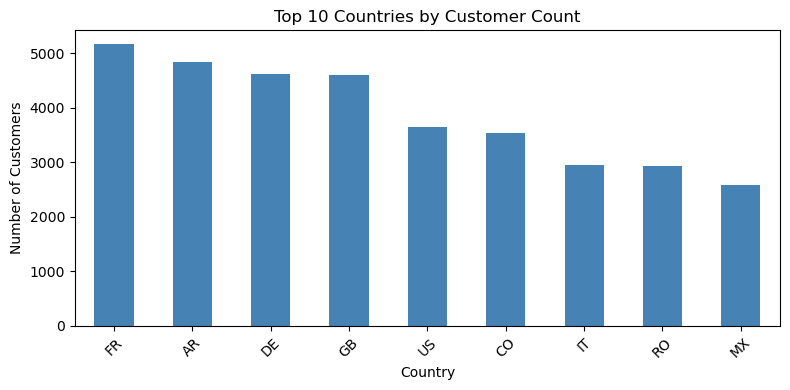

In [6]:
top_countries = train_df['pais_residencia'].value_counts().iloc[1:10]

plt.figure(figsize=(8,4))
top_countries.plot(kind='bar', color='steelblue')
plt.title("Top 10 Countries by Customer Count")
plt.ylabel("Number of Customers")
plt.xlabel("Country")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()